# Topic 19: Bode Design
## VDV 8.18 (19-7)

In [15]:
import requests as req
URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]
try:
    %run basic_material.py
    print('Basic file found')
except:    
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

from control.matlab import tf, lsim, step, rlocus, feedback, rss, lsim, c2d
from control import bode_plot, nyquist_plot
from control_materials import *
j = complex(0,1)

Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found
Basic file found


In [16]:
G = tf(1,[1, 1]) * tf(1,[1, 4])**2
PM = 48 # desired phase margin
w = logspace(-2,np.log10(10),3000)
[Gm,Gp,Gw] = bode_plot(G,plot=False,omega=w)

# if using a gain, find K so PM \approx 48, so try using
wc_des = np.interp(-180+PM,np.flipud(Gp*r2d),np.flipud(Gw))
print(f"{wc_des = : 4.3f} rad/sec")

Gf = G(j*wc_des)
K_wc = 1/np.abs(Gf)
print(f"{K_wc = : 4.3f}")


wc_des =  2.493 rad/sec
K_wc =  59.660


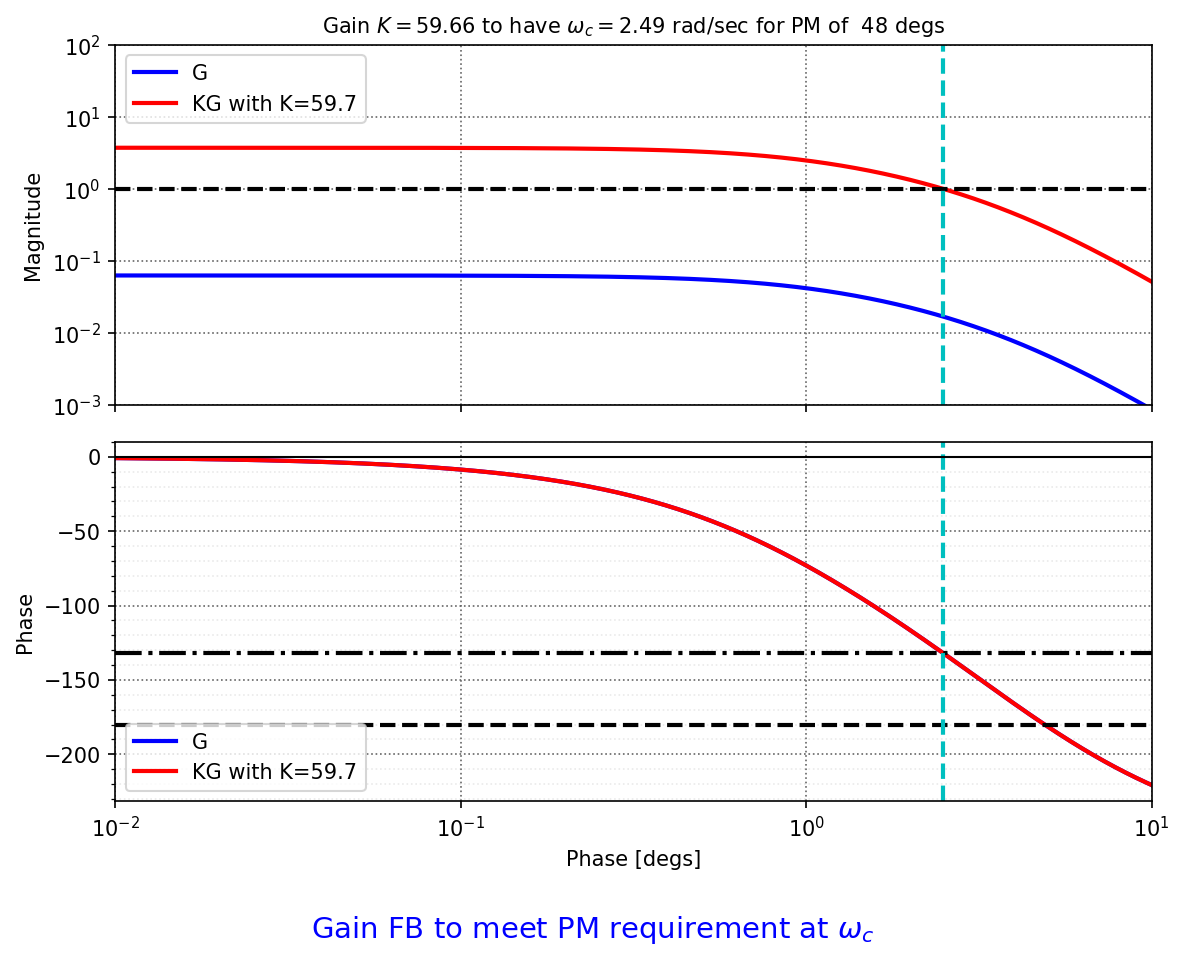

In [19]:
fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)
ax[0].loglog(Gw,Gm,'b-',label='G')
ax[0].loglog(Gw,K_wc*Gm,'r-',label='KG with K={:3.1f}'.format(K_wc))
ax[0].axhline(y=1,c='k',ls="--")
ax[0].axvline(x=wc_des,c='c',ls="--")
ax[0].set_title('Gain $K=${:3.2f} to have $\omega_c=${:3.2f} rad/sec for PM of {:3.0f} degs'.format(K_wc,wc_des,PM))
ax[0].legend()
ax[0].set_ylim([.001,100])
ax[0].set_ylabel("Magnitude")

ax[1].semilogx(Gw,pshift(Gp)*r2d,'b-',label='G')
ax[1].semilogx(Gw,pshift(Gp)*r2d,'r-',label='KG with K={:3.1f}'.format(K_wc))
ax[1].axhline(y=-180,c='k',ls="--")
ax[1].axhline(y=-180+PM,c='k',ls="-.")
ax[1].axvline(x=wc_des,c='c',ls="--")
ax[1].legend()
ax[1].set_xlim([min(w),max(w)])
ax[1].set_ylabel("Phase")
#ax[1].set_ylim([-270,0])
ax[1].set_xlabel("Frequency [rad/sec]")
ax[1].set_xlabel("Phase [degs]")
caption("Gain FB to meet PM requirement at $\omega_c$",fig)
plt.legend()
nicegrid(ax)
savefig("./figs/L17_13.pdf", dpi=600)
plt.show()


### design Lag to decrease SS error by factor of 10 (keep PM of about 42)

In [ ]:
Gc_lag = lag_design(gain_inc = 10, gamma = 10, wc = wc_des)
print("Lag Gc = ",Gc_lag)

L_lag = K_wc*G*Gc_lag
Gcl_K = feedback(K_wc*G,1)
Gcl_lag = feedback(L_lag,1)

[Gm,Gp,Gw] = bode_plot(K_wc*G,plot=False,omega=w)
[Gcm,Gcp,Gcw] = bode_plot(Gc_lag,plot=False,omega=w)
[Lcm,Lcp,Lcw] = bode_plot(L_lag,plot=False,omega=w)

PM_gain = 180+np.interp(1,np.flipud(Gm),np.flipud(Gp)*r2d)
PM_lag = 180+np.interp(1,np.flipud(Lcm),np.flipud(Lcp)*r2d)

Lag Gc =  <TransferFunction>: sys[29]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s + 0.2493
-----------
s + 0.02493



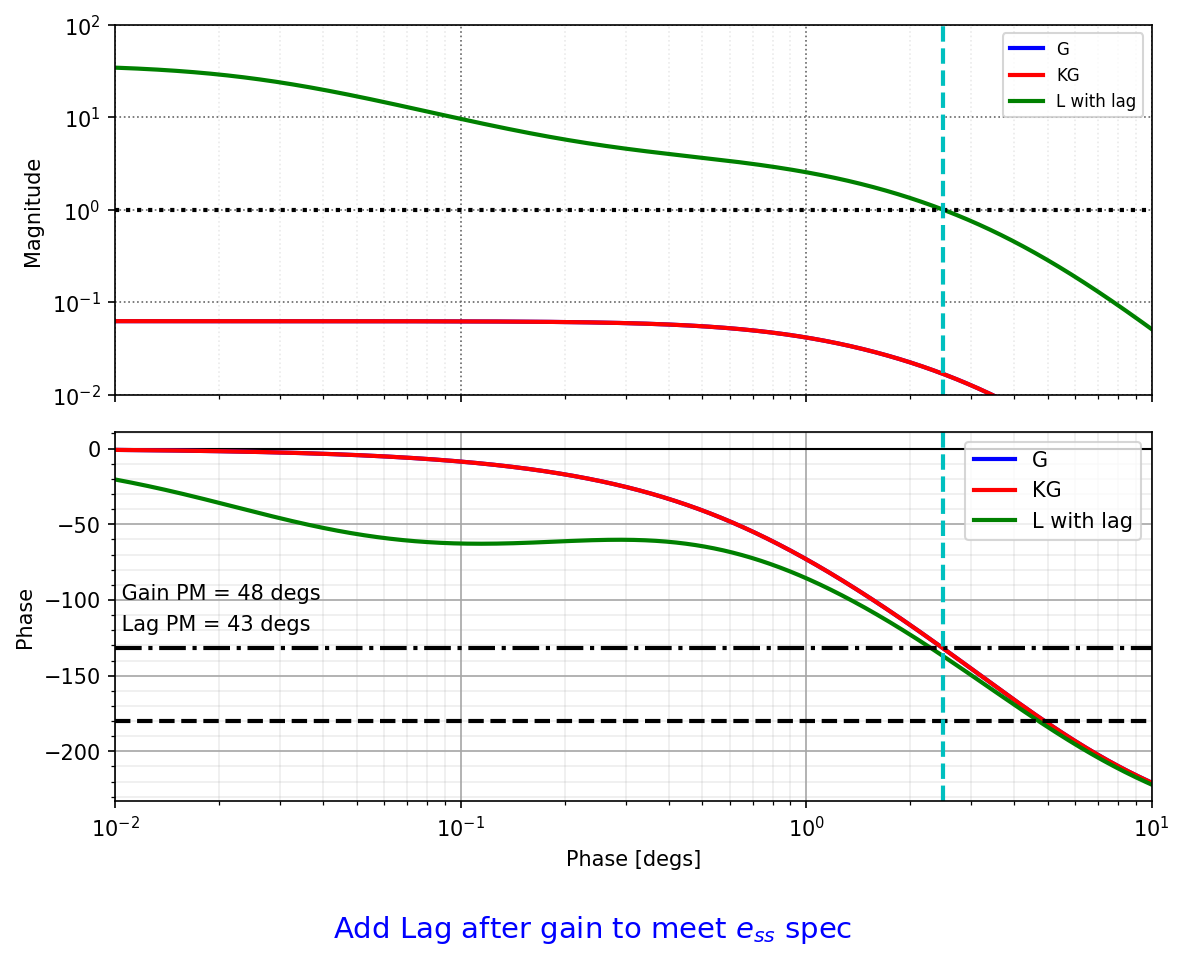

In [21]:
fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)
ax[0].loglog(Gw,Gm,'b-',label='G')
ax[0].loglog(Gw,Gm,'r-',label='KG')
ax[0].loglog(Lcw,Lcm,'g-',label='L with lag')
ax[0].axhline(y=1,c='k',ls=":")
ax[0].axvline(x=wc_des,c='c',ls="--")
ax[0].legend(fontsize=8)
ax[0].set_ylim([.01,100])
ax[0].set_ylabel("Magnitude")
nicegrid(ax)
ax[1].text(.01,-100,' Gain PM ={:3.0f} degs'.format(PM_gain))
ax[1].text(.01,-120,' Lag PM ={:3.0f} degs'.format(PM_lag))

ax[1].semilogx(Gw,pshift(Gp)*r2d,'b-',label='G')
ax[1].semilogx(Gw,pshift(Gp)*r2d,'r-',label='KG')
ax[1].semilogx(Lcw,pshift(Lcp)*r2d,'g-',label='L with lag')
ax[1].axhline(y=-180,c='k',ls="--")
ax[1].axhline(y=-180+PM,c='k',ls="-.")
ax[1].axvline(x=wc_des,c='c',ls="--")
ax[1].legend(fontsize=8)
ax[1].set_xlim([min(w),max(w)])
ax[1].set_ylabel("Phase")
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[1].set_xlabel("Frequency [rad/sec]")
ax[1].set_xlabel("Phase [degs]")
caption("Add Lag after gain to meet $e_{ss}$ spec",fig)
plt.legend()
savefig("./figs/L17_14.pdf", dpi=600)
plt.show()

## check SS error in step


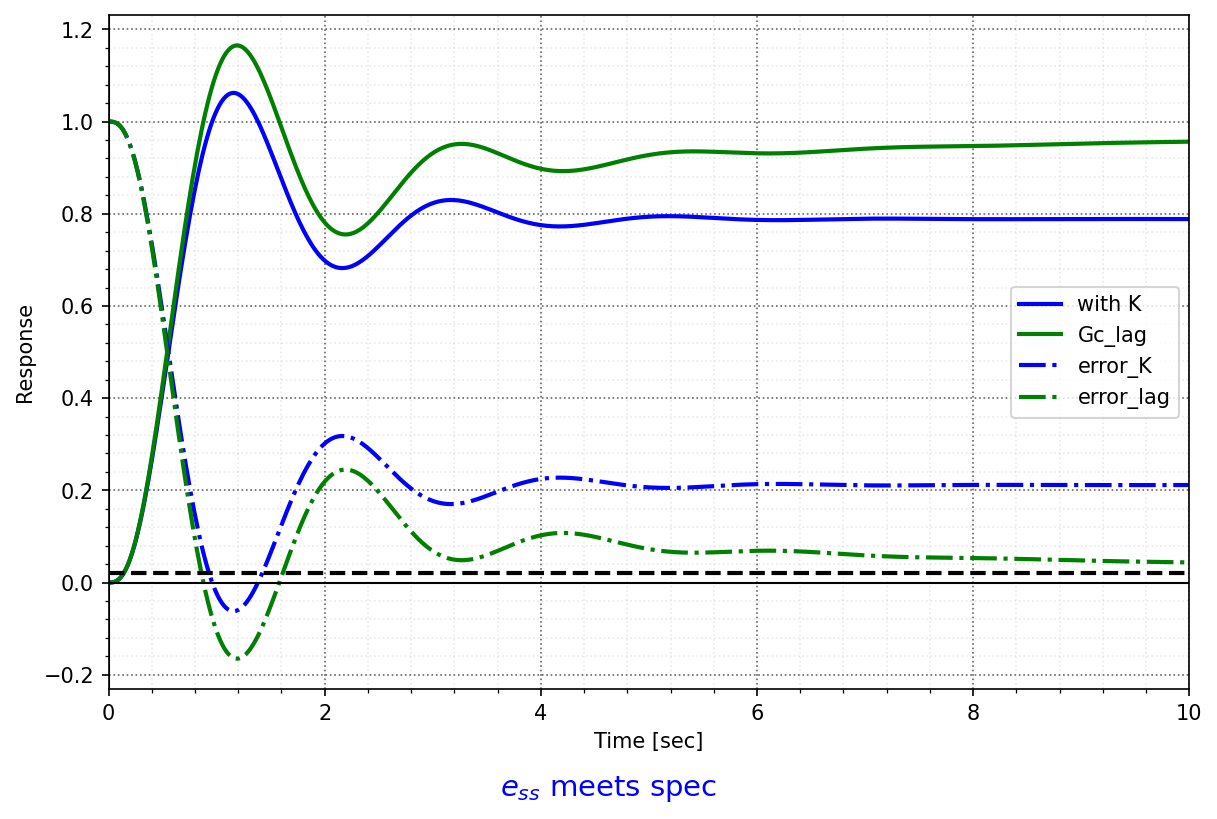

In [ ]:
Tf = 10
y_K,t_K = step(Gcl_K,Tf)
y_lag,t_lag = step(Gcl_lag,Tf)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax.plot(t_K,y_K,'b-',label='with K')
ax.plot(t_lag,y_lag,'g-',label='Gc_lag')
ax.plot(t_K,1-y_K,'b-.',label='error_K')
ax.plot(t_lag,1-y_lag,'g-.',label='error_lag')
ax.axhline(y = (1-y_K[-1])/10,color='k',ls='--')
nicegrid(ax)
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Response')
plt.legend()
caption("$e_{ss}$ meets spec",fig,yloc=-0.05)
savefig("./figs/L17_14a.pdf", dpi=600)
plt.show()
